In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


#### This example intends to show how to execute models together with Tensorboard, a tool for visualization of gradient descent workloads. For executing this notebook and displaying the training curve via Tensorboard, install this package using:  ``` pip install tensorboard ```

In [2]:
import warnings
import os
import time
with warnings.catch_warnings():
    
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import numpy as np
    
    from simulai.regression import OpInf
    from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
    from simulai.metrics import LyapunovUnits
    from simulai.math.differentiation import CollocationDerivative
    from simulai.metrics import L2Norm
    from simulai.optimization import Optimizer

#### Setting up the data generation.

In [3]:
save_path = '/tmp'
tol = 0.5
# These are our constants
N = 40 # Number of variables
F = 8  # Forcing

label = f"n_{N}_F_{F}"

if F==8:
    lambda_1 = 1/1.68
else:
    lambda_1 = 1/2.27

#### Generating data.

In [4]:
def Lorenz96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0 += 0.01*np.random.rand(N)  # Add small perturbation to the first variable
    
dt = 0.1
t = np.arange(0.0, 2000.0, dt)
lorenz_data = odeint(Lorenz96, x0, t)[t>=1000]

diff = CollocationDerivative(config={}, k=4)

derivative_lorenz_data = diff.solve(data=lorenz_data, x=t[t>=1000])

Performing Collocation Derivation.


#### Separating train and test datasets.

In [5]:
n_steps = t[t>=1000].shape[0]
nt = int(0.5 * n_steps)
nt_test = n_steps - nt
t_test = t[t>=1000][nt:]
time_ref = t_test
n_field = N

train_field = lorenz_data[:nt]  # manufactured nonlinear oscillator data
train_field_derivative = derivative_lorenz_data[:nt]

test_field = lorenz_data[nt:]  # manufactured nonlinear oscillator data
test_field_derivative = derivative_lorenz_data[nt:]

init_state = train_field[-1:]
tags = [fr'x_{i}' for i in range(n_field)]

#### Neural net model.

In [6]:
def model():

    from simulai.regression import DenseNetwork

    # Configuration for the fully-connected network
    config = {
                'layers_units': [128, 128, 128, 128],
                'activations': 'sin',
                'input_size': N,
                'output_size': N,
                'name': 'l96_net'
             }

    # Instantiating and training the surrogate model
    net = DenseNetwork(**config)

    return net

#### Instantiating neural net model. 

In [7]:
net = model()
net.summary()

Module sin not found in <module 'torch' from '/home/jalmeida/.conda/envs/torchsimulaienv/lib/python3.9/site-packages/torch/__init__.py'>.
Module sin found in <module 'simulai.activations' from '/home/jalmeida/Projetos/opensource/simulai/src/simulai/activations.py'>.
Summary of the network properties:
Linear operations layers:

[ Linear(in_features=40, out_features=128, bias=True),
  Linear(in_features=128, out_features=128, bias=True),
  Linear(in_features=128, out_features=128, bias=True),
  Linear(in_features=128, out_features=128, bias=True),
  Linear(in_features=128, out_features=40, bias=True)]


Activations layers:

['sin', 'sin', 'sin', 'sin', 'identity']


Initializations at each layer:

['xavier', 'xavier', 'xavier', 'xavier', 'xavier']


#### Configuring Optimizer.
#### The argument `summary_writer` for the class  `Optimizer` allows PyTorch to record execution data in order to be displayed by Tensorboard. 

#### When the execution of the cell below is started, in another terminal tab run ``` tensorboard --logdir=./runs``` and open the link displayed in the screen (http://localhost:6006/) in a browser. 

In [8]:
lr = 1e-3
n_epochs = 2_000

optimizer_config = {'lr': lr}

params = {'lambda_1': 0., 'lambda_2': 1e-10}

optimizer = Optimizer('adam', params=optimizer_config, summary_writer=True)

optimizer.fit(op=net, input_data=train_field, target_data=train_field_derivative,
              n_epochs=n_epochs, loss="rmse", params=params, device='gpu')

Optimizer adam found in <module 'torch.optim' from '/home/jalmeida/.conda/envs/torchsimulaienv/lib/python3.9/site-packages/torch/optim/__init__.py'>.
loss: 11.87435245513916  

#### Tensorboard will display the task progress such as following:
![](figs/tensorboard_view.jpg)

#### Using the neural net for estimating output

In [9]:
estimated_field = net.eval(input_data=test_field)

#### 1D Plots

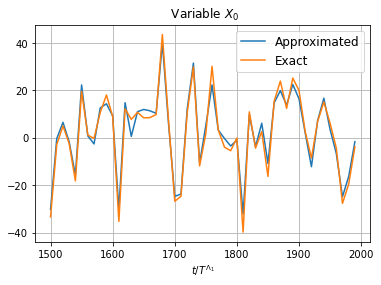

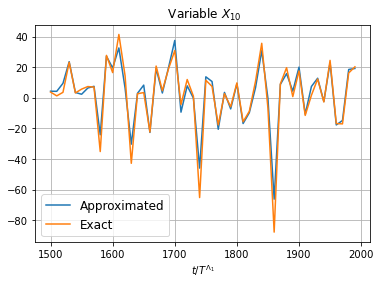

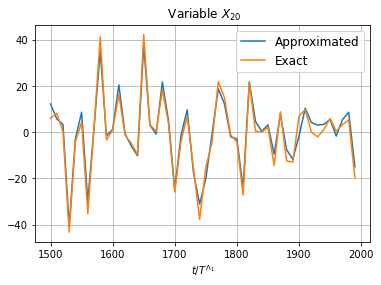

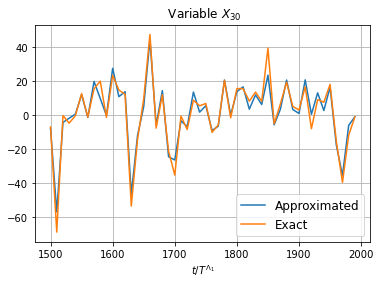

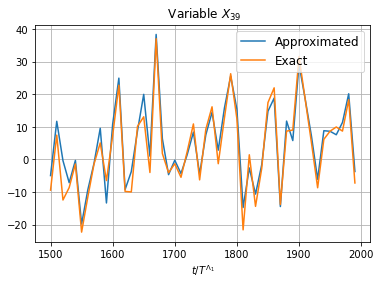

In [11]:
vars = [0, 10, 20, 30, 39]

for vv in vars:
    plt.plot(time_ref[::100], estimated_field[::100, vv], label="Approximated")
    plt.plot(time_ref[::100], test_field_derivative[::100, vv], label="Exact")
    plt.title(rf" Variable $X_{str({vv})}$")
    plt.xlabel(r"$t/T^{\Lambda_1}$")
    #plt.xlim(0, 20)
    plt.grid(True)
    plt.legend(fontsize=12.)
    plt.savefig(os.path.join(save_path, f"evaluation_{vv}_{label}"))
    plt.show()